# <b>Fondamenti di Analisi Dati</b> - a.a. 2020/2021

# 16 Classificazione Nearest Neighbor (K-NN)

Un classificatore Nearest Neighbor (K-NN) permette di classificare i dati confrontandoli con un insieme pre-esistente di dati etichettati (il training set). Sia $\mathbf{X}=\{(\mathbf{x}_i, y_i)\}_{i=1}^N$ un dataset etichettato, dove $\mathbf{x}_i$ rappresentano i campioni del dataset e $y_i$ rappresentano le relative etichette e sia $\overline{\mathbf{x}}$ un nuovo campione di test da classificare. L'algoritmo K-NN cerca prima i $K$ campioni del training set più simili a $\overline{\mathbf{x}}$ secondo una qualche misura di similarity $\delta$. La classificazione avviene dunque assegnando a $\overline{\mathbf{x}}$ l'etichetta più frequente fra le $K$ etichette $y_i$ dei campioni di training trovati. Per evitare situazioni di incertezza, di solito si sceglie un valore di $K$ non multiplo del numero di classi. Nel caso in cui $K = 1$, l'algoritmo assegna a $\overline{\mathbf{x}}$ l'etichetta del campione più simile nel training set.

Vediamo un esempio con il dataset degli iris di Fisher. Carichiamo il dataset:

In [1]:
from statsmodels.datasets import get_rdataset
fisher = get_rdataset('iris')
fisher.data.head()

C:\Users\visig\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Consideriamo per il momento solo due features, ma consideriamo tutte e tre le classi:

In [2]:
import pandas as pd
data = fisher.data
#costruiamo un dataframe vuoto
df = pd.DataFrame()
#inserieamo le prime due feature e chiamiamole X e Y
df['X'] = data['Sepal.Length']
df['Y'] = data['Sepal.Width']
#inseriamo una colonna "C" che contenga le classi
df['C'] = data['Species']

data = df
data.head()

,X,Y,C
0,5.1,3.5,setosa
1,4.9,3.0,setosa
2,4.7,3.2,setosa
3,4.6,3.1,setosa
4,5.0,3.6,setosa


Suddividiamo adesso il dataset in training e test set:

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

#dato che il dataset è molto piccolo, prendiamo il 75% dei dati per formare il training set
np.random.seed(134)
data_training, data_test = train_test_split(data,test_size=0.25)

print("Numero di campioni di training:",len(data_training))
print(data_training.head())
print()
print("Numero di campioni di test:",len(data_test))
print(data_test.head())

Numero di campioni di training: 112
       X    Y           C
60   5.0  2.0  versicolor
143  6.8  3.2   virginica
144  6.7  3.3   virginica
127  6.1  3.0   virginica
8    4.4  2.9      setosa

Numero di campioni di test: 38
       X    Y           C
65   6.7  3.1  versicolor
46   5.1  3.8      setosa
99   5.7  2.8  versicolor
101  5.8  2.7   virginica
47   4.6  3.2      setosa


Visualizziamo i campioni di training e test nello spazio 2D:

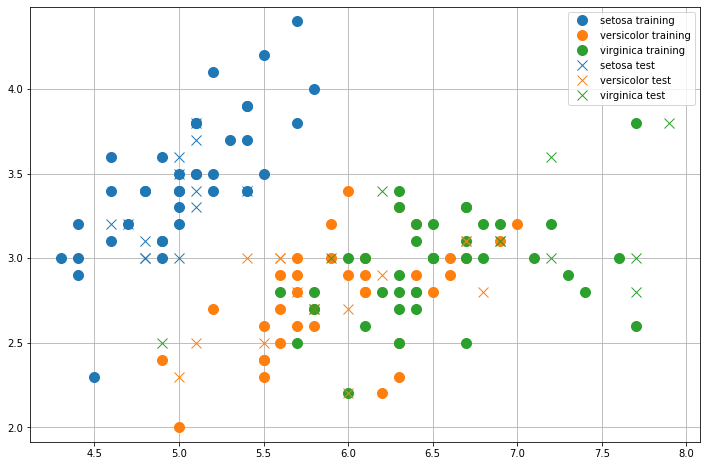

In [4]:
from matplotlib import pyplot as plt
def plot2d(data, label_suffix='', marker='o'):
    classes = sorted(data['C'].unique())
    for c in classes:
        plt.plot(data.where(data['C']==c).dropna().X.values,
                 data.where(data['C']==c).dropna().Y.values,'o', label=c+label_suffix, marker=marker, markersize=10)

    plt.axis('equal')

plt.figure(figsize=(12,8))
plot2d(data_training,' training', marker='o')

#reset dei colori: in questo modo avrò gli stessi colori per training e test set (ripartendo dal blu)
plt.gca().set_prop_cycle(None) 
plot2d(data_test,' test', marker='x')
plt.grid()
plt.legend()
plt.show()

Costruiamo adesso un classificatore 1-NN mediante scikit-learn:

In [5]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn_1 = KNN(n_neighbors=1)
knn_1.fit(data_training.drop('C',axis=1), data_training.C)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Di default, il classificatore verrà costruito considerando la distanza Euclidea come misura di similarità tra i campioni. Calcoliamo adesso le accuracy di training e test:

In [6]:
print("Accuracy sul training set: %0.2f" % knn_1.score(data_training.drop('C',axis=1), data_training.C))
print("Accuracy sul test set: %0.2f" %  knn_1.score(data_test.drop('C',axis=1), data_test.C))

Accuracy sul training set: 0.95
Accuracy sul test set: 0.74


L'algortimo KNN suddivide implicitamente lo spazio dei dati in delle regioni di decisione, dove il valore di decisione in un particolare punto dello spazio dipende dalla classe di appartenenza dei K vicini più prossimi. Per visualizzare le regioni di decisione e dunque il decision boundary, possiamo effettuare la classificazione per una griglia uniforme di punti:

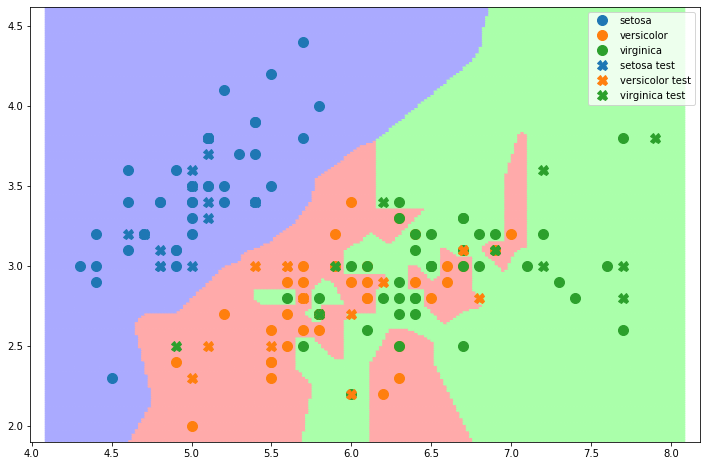

In [7]:
import numpy as np
from matplotlib.colors import ListedColormap
#creiamo una colormap per mostrare le regioni di decisione
cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA' ])
import matplotlib.patches as mpatches

def plot_knn_decision_boundary(data, knn):
    plot2d(data)
    X = np.linspace(data['X'].min()*0.95, data['X'].max()*1.05,200)
    Y = np.linspace(data['Y'].min()*0.95, data['Y'].max()*1.05,200)
    X,Y = np.meshgrid(X,Y)
    
    Z = knn.predict(np.c_[X.ravel(), Y.ravel()])
    
    #costruiamo un dizionario per transformare le stringhe in indici
    class_dict = {c:i for i,c in enumerate(knn.classes_)}
    
    Z=list(map(lambda x: class_dict[x],Z))
    Z = np.array(Z).reshape(X.shape)
    
    plt.pcolormesh(X, Y, Z, antialiased=True, cmap=cmap_light)
    #plt.contour(X,Y,Z)

plt.figure(figsize=(12,8))
plot_knn_decision_boundary(data_training,knn_1)
plt.gca().set_prop_cycle(None)
plot2d(data_test,label_suffix=' test', marker='X')
plt.legend()

plt.show()

Proviamo adesso a costruire un classificatore $7-NN$:

In [8]:
knn_7 = KNN(n_neighbors=7)
knn_7.fit(data_training.drop('C',axis=1), data_training.C)
print("Accuracy sul training set: %0.2f" % knn_7.score(data_training.drop('C',axis=1), data_training.C))
print("Accuracy sul test set: %0.2f" %  knn_7.score(data_test.drop('C',axis=1), data_test.C))

Accuracy sul training set: 0.84
Accuracy sul test set: 0.82


Visualizziamo il decision boundary di questo classificatore:

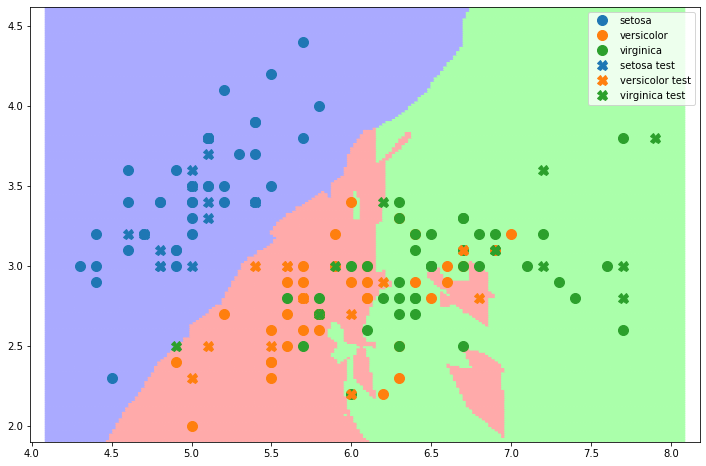

In [9]:
plt.figure(figsize=(12,8))
plot_knn_decision_boundary(data_training,knn_7)
plt.gca().set_prop_cycle(None)
plot2d(data_test,label_suffix=' test', marker='X')
plt.legend()

plt.show()

### 16.1 Trovare il valore ottimale di K

Abbiamo visto come diverse scelte di valori per il parametro $K$ permettano di modificare il decision boundary trovato implicitamente dall'algoritmo $K-NN$. In particolare abbiamo visto come, a seconda di come i dati si distribuiscono nello spazio, un valore più alto di $K$ permetta di ridurre l'influenza di alcuni outliers, mentre un valore più basso di $K$ permette di delineare un decision boundary più accurato. Va notato che il valore ottimale di $K$ dipende dai dati sui quali stiamo lavorando. Proviamo ad esempio a vedere come varia l'accuracy di training per diverse scelte di $K$:

Migliore accuracy di test: 0.87
Migliore k: 9.00


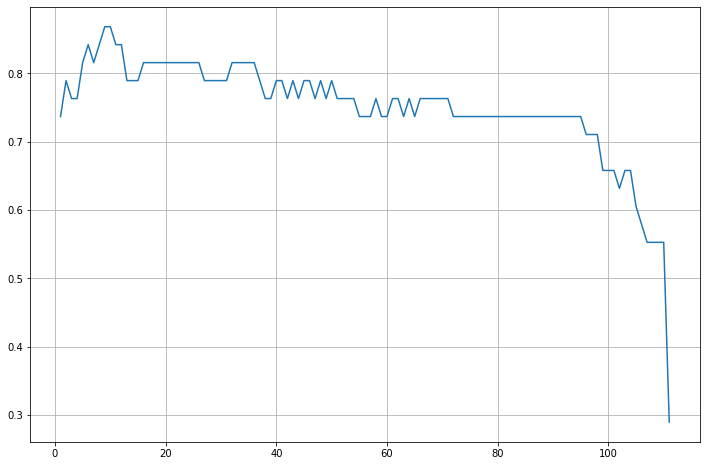

In [10]:
test_accuracies = []
k_values = range(1,len(data_training)) 
for k in k_values:
    knn = KNN(n_neighbors=k)
    knn.fit(data_training.drop('C',axis=1), data_training.C)
    test_accuracies.append(knn.score(data_test.drop('C',axis=1), data_test.C))

best_index = np.argmax(test_accuracies)
best_k = k_values[best_index]
best_accuracy = test_accuracies[best_index]
print("Migliore accuracy di test: %0.2f" % best_accuracy)
print("Migliore k: %0.2f" % best_k)
    
plt.figure(figsize=(12,8))
plt.plot(k_values,test_accuracies)
plt.grid()
plt.show()

Abbiamo scoperto qual è il $K$ ottimale (dal training set) per il nostro dataset e qual è la migliore accuracy (sul test set) raggiungibile. Tuttavia, dobbiamo sempre ricordare che i dati di test non sono disponibili in fase di training, per cui **non dovremmo mai utilizzarli per scegliere i valori dei parametri**. Dunque possiamo scegliere il migliore $k$ solo utilizzando il training set. Ciò si può fare utilizzando l'oggetto GridSearchCV come visto nel caso di SVM:

In [11]:
from sklearn.model_selection import GridSearchCV
#definiamo la griglia di parametri.
param_grid = [ {'n_neighbors':range(1,50)}]
#definiamo l'oggetto Grid Search
gs = GridSearchCV(KNN(), param_grid)
#avviamo la ricerca.
gs.fit(data_training.drop('C',axis=1), data_training.C)
best_knn = gs.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 24


Il miglior valore di $K$ trovato in questa maniera può differire da quello trovato utilizzando il test set. Vediamo che accuracy di test otteniamo utilizzando il miglior modello trovato:

In [12]:
print("Accuracy su test set con miglior K trovato sul training set: %0.2f" % \
        best_knn.score(data_test.drop('C',axis=1), data_test.C))

Accuracy su test set con miglior K trovato sul training set: 0.82


### 16.2 Editing del Training Set

Un classificatore di tipi K-NN basa le sue scelte su un insieme di campioni di training che vengono esplicitamente memorizzati. Quando il training set è molto grande, il tempo computazione richiesto da un classificatore K-NN tende a crescere. Per ridurre il tempo di computazione, è possibile applciare tecniche di editing del training set. Queste tecniche cercano di ridurre la dimensione del training set rimuovendo i campioni inessenziali per le scelte del K-NN. In particolare, esistono due tecniche di editing usate classicamente: **condense** e **multiedit**. 

#### 16.2.1 Condense
L'algoritmo **condense** può essere sintetizzato come segue:

 1. Seleziona casualmente un campione dal training set e inseriscilo nell'insieme $R$;
 2. Per ogni campione di training $i=1,\ldots,n$: classifica il campione $i$ utilizzando un classificatore 1-NN costruito utilizzando $R$ come training set. Inserisci il campione $i$ se è stato classificato erroneamente;
 3. Ripeti il punto 2 se $R$ è stato modificato durante durante l'esecuzione del punto 2;
 4. Restituisci $R$.
 
L'algoritmo **condense** cerca di rimuovere i campioni ridondanti, ovvero quelli che non contribuiscono significativamente alla definizione del decision boundary. Vediamo una possibile implementazione di **condense**:

In [13]:
def condense(data, target):
    #utilizzeremo l'array "selected" per tenere traccia dei campioni che sono stati
    #selezionati dall'algoritmo. In particolare, gli indici "i" in corrispondenza dei quali
    #selected[i] è diverso da zero, indicano che data[i] è stato selezionato dall'algoritmo
    #inizializziamo selected con degli zeri. Nessun dato è stato selezionato
    selected = np.zeros(len(data)).astype(bool)
    
    #Step 1: selezioniamo un campione casuale e mettiamolo nell'insieme degli elementi selezionati
    i = np.random.choice(range(len(data))) #scegliamo un indice casuale
    selected[i] = 1
   
    knn = KNN(n_neighbors=1)
    #Step 2: classifichiamo ogni campione non selezionato utilizzando i campioni selezionati come training set
    #ripetiamo la procedura finché non abbiamo più nessun campione da inserire
    finished = False
    while not finished: #finché la variabile finished è False
        #questa variabile ci ricorda se abbiamo inserito nuovi elementi in questa iterazione del while
        selected_new_elements = False
        for i in range(len(data)): #per ogni campione
            if not selected[i]: #se il campione non è stato selezionato
                knn.fit(data[selected],target[selected]) #alleniamo il knn con i campioni selezionati
                if knn.predict(data[i].reshape((1,2)))[0]!=target[i]: #se il campione è stato classificato male
                    selected[i]=1 #selezioniamolo
                    selected_new_elements = True #e indichiamo che abbiamo selezionato almeno un nuovo elemento
        if selected_new_elements == False: #se finito il for non abbiamo selezionato nessun nuovo elemento
            finished=True #allora bbiamo finito
    return data[selected], target[selected] #restituiamo solo i dati che sono stati selezionati

Applichiamo l'algoritmo sui nostri dati:

In [14]:
condensed_data, condensed_target = condense(data_training.drop('C',axis=1).values, data_training['C'].values)
data_condensed = pd.DataFrame()
data_condensed['X'] = condensed_data[:,0]
data_condensed['Y'] = condensed_data[:,1]
data_condensed['C'] = condensed_target

print("Numero di campioni nel training set: %d" % len(data_training))
print("Numero di campioni nel training set condensato: %d" % len(data_condensed))
print("Percentuale di dati rimossi: %0.2f" % (float(len(data_training)-len(data_condensed))/len(data_training)*100))

Numero di campioni nel training set: 112
Numero di campioni nel training set condensato: 50
Percentuale di dati rimossi: 55.36


L'algoritmo condense ci permette di selezionare un numero limitato di campioni di training. Cerchiamo di capire quali campioni sono stati selezionati:

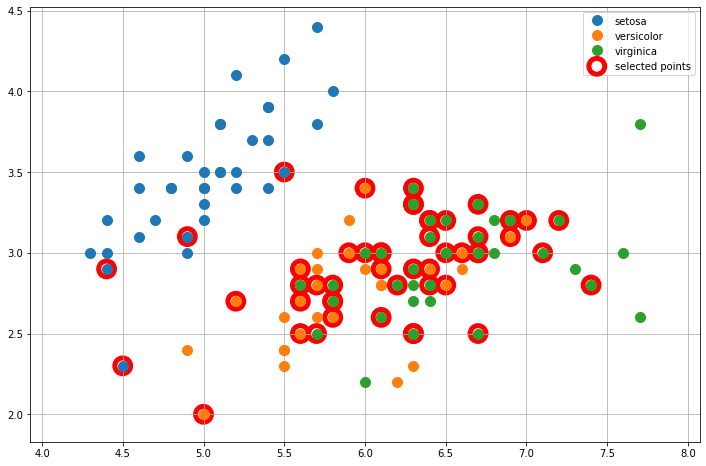

In [15]:
plt.figure(figsize=(12,8))
plot2d(data_training)
plt.scatter(data_condensed.X, data_condensed.Y, 250,
                facecolors='none',edgecolors='r', linewidth=5, label='selected points')
plt.grid()
plt.legend()
plt.show()

Adesso confrontiamo i classificatori 1-NN costruiti rispettivamente sul training set originale e sulla sua versione condensata.

In [16]:
knn = KNN(n_neighbors=1)
knn_condensed = KNN(n_neighbors=1)
knn.fit(data_training.drop('C',axis=1), data_training['C'])
knn_condensed.fit(data_condensed.drop('C',axis=1), data_condensed['C'])

print("Accuracy di test per 1-NN su training set originale: %0.2f" % \
    knn.score(data_test.drop('C',axis=1), data_test.C))
print("Accuracy di test per 1-NN su training set condensato: %0.2f" % \
    knn_condensed.score(data_test.drop('C',axis=1), data_test.C))

Accuracy di test per 1-NN su training set originale: 0.74
Accuracy di test per 1-NN su training set condensato: 0.71


I due classificatori hanno performance simili, tuttavia quello basato su training set condensato basa le proprie decisioni su un numero significativamente inferiore di dati e dunque occupa meno spazio ed è più veloce. Cerchiamo di capire in che modo cambia il decision boundary individuato dal KNN su training set condensato. Mostriamo i due training set con i relativi decision boundary uno di fianco all'altro:

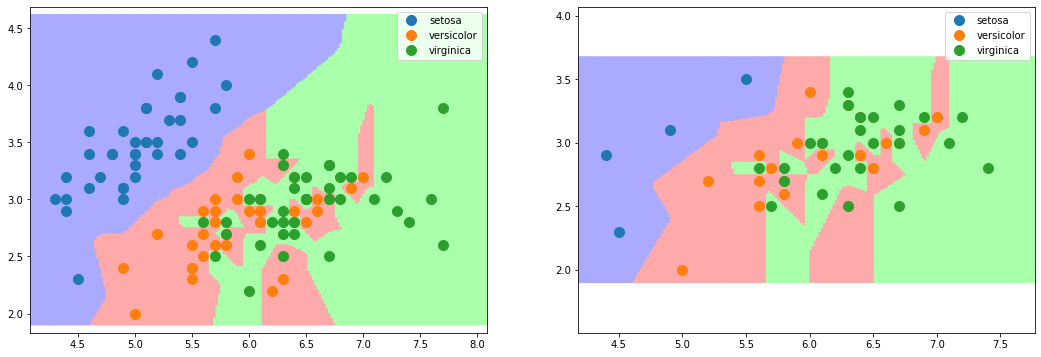

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plot_knn_decision_boundary(data_training,knn)
plt.legend()
plt.subplot(122)
plot_knn_decision_boundary(data_condensed,knn_condensed)
plt.legend()
plt.show()

### 1.2.2 Multiedit

L'algoritmo **multiedit** può essere riassunto come segue:
 1. Dividere casualmente il training set in $s$ split $S_1, S_2, \ldots, S_s$. Sia $f_i$ il classificatore 1-NN che utilizza $S_i$ come training set;
 2. Per ogni i, si classifichino tutti i campioni di $S_i$ utilizzando il classificatore $f_{(i+1)\ mod\ s}$;
 3. Si scartino tutti i campioni classificati erroneamente;
 4. Si raccolgano tutti i campioni rimanenti e si ritorni al passo 1 se qualche campione è stato scartato nelle ultime $T$ iterazioni;
 5. I campioni rimanenti costituiscono il nuovo training set.
 
L'algoritmo **multiedit** cerca di rimuovere dal set i campioni ambigui che si trovano "dalla parte sbagliata" del decision boundary.

In [18]:
def multiedit(data, target, s=5, T=3):
    #L'algoritmo ha due parametri: s e T. Noi scegliamo
    #s=5 (5 split) e T=3 (termina dopo tre iterazione senza errori di classificazione)
    #come parametri di default
    
    #otteniamo una lista di tutti gli indici dei dati
    all_indices = np.array(range(len(data)))
    #finished indica quando abbiamo finito
    finished = False
    #teniamo traccia delle iterazioni passate dall'ultima volta che abbiamo scartato un campione
    iterations_since_last_change = 0
    knn = KNN(n_neighbors=1)
    while not finished:
        #indica se abbiamo modificato il set in questa iterazione
        edited = False
        
        #suddividiamo gli indici in 3 split casuali
        #per far si che gli split siano casuali, prima effettuiamo una permutazione degli indici
        split_indices = np.array_split(np.random.permutation(all_indices),s)
        
        #questa lista conterrà tutti gli indici degli elementi che sono stati classificati male
        #e vanno rimossi
        mark_for_removal = []

        #per ogni split
        for i in range(s):
            #calcoliamo gli indici degli elementi di training e test
            j = (i+1)%s
            idx_test = split_indices[i]
            idx_train = split_indices[j]
            
            #alleniamo il classificatore 1-NN usando gli elementi di training
            knn.fit(data[idx_train],target[idx_train])
            
            #classifichiamo gli elementi di test
            predictions = knn.predict(data[idx_test])
            
            #contrassegnamo per la rimozione tutti gli elementi che sono stati classificati male
            mark_for_removal.extend(idx_test[np.where(predictions!=target[idx_test])])
            
            #se abbiamo classificato male qualche campione, impostiamo edited a True
            if all(predictions!=target[idx_test]):
                edited = True
                
        #rimuoviamo gli indici che avevamo contrassegnato per la rimozione
        all_indices = np.setdiff1d(all_indices, mark_for_removal)
        
        #se non abbiamo modificato il set
        if not edited:
            #incrementiamo il numero di iterazioni dall'ultimo cambiamento
            iterations_since_last_change+=1
            
        #condizione di terminazione
        if iterations_since_last_change>=T:
            finished=True
    
    #restituiamo il nuovo set
    return data[all_indices], target[all_indices]

Applichiamo l'algoritmo sui nostri dati:

In [19]:
multiedited_data, multiedited_target = multiedit(data_training.drop('C',axis=1).values, \
                                                 data_training['C'].values)

data_multiedited = pd.DataFrame()
data_multiedited['X'] = multiedited_data[:,0]
data_multiedited['Y'] = multiedited_data[:,1]
data_multiedited['C'] = multiedited_target

Adesso alleniamo il classificatore 1-NN e confrontiamo le performance rispetto a 1-NN su training set originale:

In [20]:
knn = KNN(n_neighbors=1)
knn_multiedited = KNN(n_neighbors=1)
knn.fit(data_training.drop('C',axis=1), data_training.C)
knn_multiedited.fit(data_multiedited.drop('C',axis=1), data_multiedited.C)

print("Accuracy di test per 1-NN su training set originale: %0.2f" % \
    knn.score(data_test.drop('C',axis=1), data_test.C))
print("Accuracy di test per 1-NN su training set multieditato: %0.2f" % \
    knn_multiedited.score(data_test.drop('C',axis=1), data_test.C))

Accuracy di test per 1-NN su training set originale: 0.74
Accuracy di test per 1-NN su training set multieditato: 0.79


Visualizziamo quali punti sono stati selezionati dall'algoritmo **multiedit**:

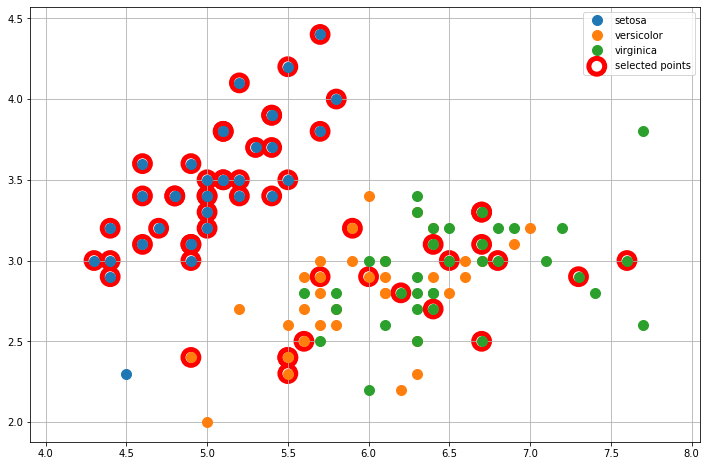

In [21]:
plt.figure(figsize=(12,8))
plot2d(data_training)
plt.scatter(data_multiedited.X, data_multiedited.Y, 250,
                facecolors='none',edgecolors='r', linewidth=5, label='selected points')
plt.grid()
plt.legend()
plt.show()

Visualizziamo dunque in che modo l'algoritmo **multiedit** cambia il decision boundary:

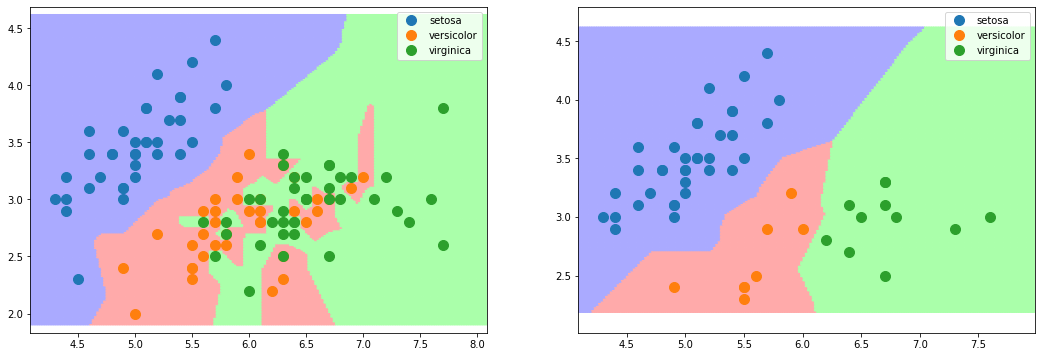

In [22]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plot_knn_decision_boundary(data_training,knn)
plt.legend()
plt.subplot(122)
plot_knn_decision_boundary(data_multiedited,knn_multiedited)
plt.legend()
plt.show()

Dopo aver applicato l'algoritmo **multiedit**, si può ridurre ulteriormente la dimensione del training set utilizzando **condense**:

Numero di campioni nel training set: 112
Numero di campioni nel training set condensato: 50
Percentuale di dati rimossi: 55.36
Accuracy di test per 1-NN su training set multieditato: 0.79
Accuracy di test per 1-NN su training set multieditato e condensato: 0.79


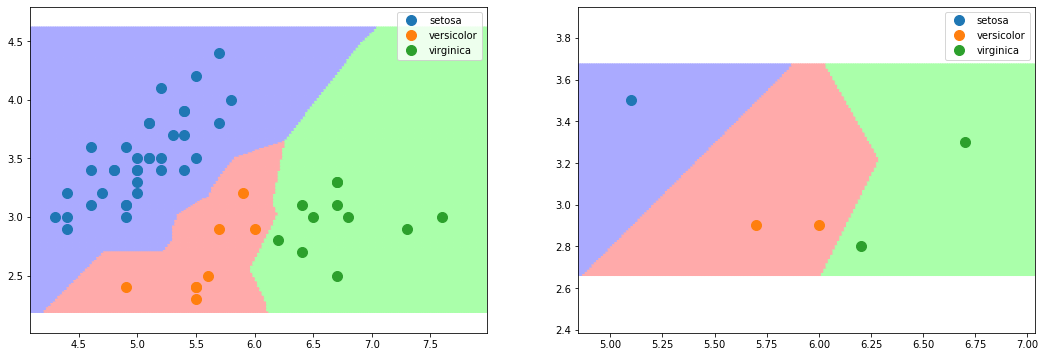

In [23]:
multiedited_condensed_data, multiedited_condensed_target = condense(data_multiedited.drop('C',axis=1).values,\
                                                                    data_multiedited.C.values)
data_multiedited_condensed = pd.DataFrame()
data_multiedited_condensed['X'] = multiedited_condensed_data[:,0]
data_multiedited_condensed['Y'] = multiedited_condensed_data[:,1]
data_multiedited_condensed['C'] = multiedited_condensed_target

print("Numero di campioni nel training set: %d" % len(data_training))
print("Numero di campioni nel training set condensato: %d" % len(data_condensed))
print("Percentuale di dati rimossi: %0.2f" % (float(len(data_training)-len(data_condensed))/len(data_training)*100))

knn_multiedited = KNN(n_neighbors=1)
knn_multiedited_condensed = KNN(n_neighbors=1)
knn_multiedited.fit(data_multiedited.drop('C',axis=1), data_multiedited.C)
knn_multiedited_condensed.fit(data_multiedited_condensed.drop('C',axis=1), data_multiedited_condensed.C)

print("Accuracy di test per 1-NN su training set multieditato: %0.2f" % \
    knn_multiedited.score(data_test.drop('C',axis=1), data_test.C))
print("Accuracy di test per 1-NN su training set multieditato e condensato: %0.2f" % \
    knn_multiedited_condensed.score(data_test.drop('C',axis=1), data_test.C))
    
plt.figure(figsize=(18,6))
plt.subplot(121)
plot_knn_decision_boundary(data_multiedited,knn_multiedited)
plt.legend()
plt.subplot(122)
plot_knn_decision_boundary(data_multiedited_condensed,knn_multiedited_condensed)
plt.legend()
plt.show()

 ## 16.2. K-Means Clustering
 
 L'algoritmo K-Means si pone l'obiettivo di trovare gruppi (**clusters**) di dati in uno spazio multidimensionale. Vediamo un esempio di uso dell'algoritmo K-Means. Consideriamo il dataset "Old Faithful". Il dataset contiene misurazioni sulle eruzioni del geyser Old Faithful nel Yellowstone National Park, USA. In particolare, ogni record riporta la durata di una eruzione e il tempo passato tra l'eruzione corrente e la successiva. Carichiamo il dataset:

In [3]:
from statsmodels.datasets import get_rdataset
faithful = get_rdataset('faithful')
print("Numero di record:",len(faithful.data))
faithful.data.head()

Numero di record: 272


,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [25]:
print(faithful.__doc__)

======== ===============
faithful R Documentation
======== ===============

Old Faithful Geyser Data
------------------------

Description
~~~~~~~~~~~

Waiting time between eruptions and the duration of the eruption for the
Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

Usage
~~~~~

::

   faithful

Format
~~~~~~

A data frame with 272 observations on 2 variables.

==== ========= ======= =======================================
[,1] eruptions numeric Eruption time in mins
[,2] waiting   numeric Waiting time to next eruption (in mins)
\                      
==== ========= ======= =======================================

Details
~~~~~~~

A closer look at ``faithful$eruptions`` reveals that these are heavily
rounded times originally in seconds, where multiples of 5 are more
frequent than expected under non-human measurement. For a better version
of the eruption times, see the example below.

There are many versions of this dataset around: Azzalini and Bowman
(1990) use a

Applichiamo una normalizzazione per media e deviazione standard (z-scoring) ai dati e plottiamoli:

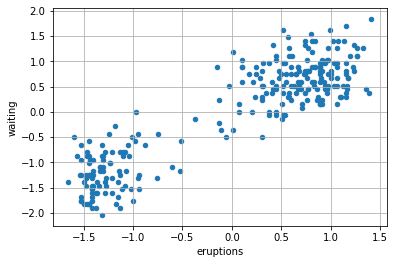

In [26]:
from matplotlib import pyplot as plt
faithful.data = (faithful.data-faithful.data.mean())/faithful.data.std()
#possiamo utilizzare la funzione "plot" dei dataframe o tutti gli altri metodi visti in precedenza
faithful.data.plot(x='eruptions',y='waiting',kind='scatter')
plt.grid()
plt.show()

Alleniamo adesso l'algoritmo K-Means specificando $2$ come numero di cluster:

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(faithful.data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

L'algoritmo K-Means ha assegnato ogni dato di training ad uno dei cluster. Possiamo accedere alla variabile degli assegmanti come segue:

In [28]:
clusters = kmeans.labels_
print(clusters)

[0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 0]


Ogni elemento è stato assegnato ad uno dei due cluster identificati con $1$ o $0$. Per comodità, costruiamo un nuovo dataframe in cui rinominiamo le variabili in "X" e "Y" e aggiungiamo una variabile "C" che indica il cluster a cui ogni record è stato associato:

In [29]:
import pandas as pd
data = pd.DataFrame()
data['X'] = faithful.data['eruptions']
data['Y'] = faithful.data['waiting']
data['C'] = clusters.astype(int)
data.head()

,X,Y,C
0,0.098318,0.596025,0
1,-1.478733,-1.242890,1
2,-0.135612,0.228242,0
3,-1.055558,-0.654437,1
4,0.915755,1.037364,0


Plottiamo dunque i dati visualizzando a quale cluster sono stati associati:

In [12]:
def plot2d(data):
    classes = sorted(data.C.unique())
    for c in classes:
        plt.plot(data.where(data.C==c).dropna().X.values,
                 data.where(data.C==c).dropna().Y.values,'o', markersize=10, label=str(c))

plt.figure(figsize=(12,8))
plot2d(data)
plt.legend()
plt.grid()
plt.show()

NameError: name 'data' is not defined

<Figure size 864x576 with 0 Axes>

Possiamo accedere ai centroidi trovati dall'algoritmo K-Means come segue:

In [31]:
kmeans.cluster_centers_

array([[ 0.70839746,  0.67549972],
       [-1.25776692, -1.19935664]])

Similmente a quanto fa un algoritmo di tipo Nearest Neighbor, anche il K-Means definisce implicitamente delle regioni di decisione e un decision boundary. Vediamo di visualizzare queste informazioni nel nostro caso:

In [32]:
def plot_kmeans_decision_boundary(data, kmeans):
    plot2d(data)
    X = np.linspace(data.X.min(), data.X.max(),200)
    Y = np.linspace(data.Y.min(), data.Y.max(),200)
    X,Y = np.meshgrid(X,Y)
    
    Z = kmeans.predict(np.c_[X.ravel(), Y.ravel()])
    
    Z = np.array(Z).reshape(X.shape)
    
    plt.pcolormesh(X, Y, Z, antialiased=True, cmap='Set3')
    
    centers = kmeans.cluster_centers_
    
    plt.plot(centers[:,0],centers[:,1],'kX',markersize=10,label='centroids')

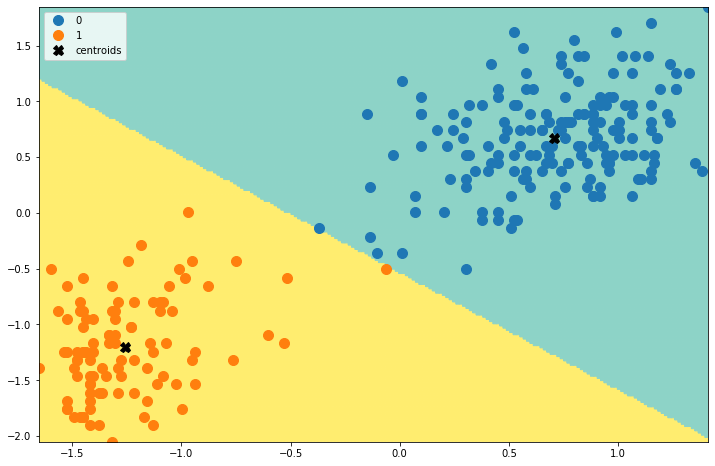

In [33]:
import numpy as np
plt.figure(figsize=(12,8))
plot_kmeans_decision_boundary(data,kmeans)
plt.legend()
plt.show()

### 16.2.1 Esempio con dataset DIGITS
 
Proviamo adesso ad utilizzare un dataset più grande con campioni a più dimensioni. Consideriamo il dataset "digits" di cifre scritte a mano messo a disposizione da scikit-learn:

In [34]:
from sklearn.datasets import load_digits
digits = load_digits()
print("Numero di campioni: %d, Numero di dimensioni: %d" % digits.data.shape)

Numero di campioni: 1797, Numero di dimensioni: 64


Ricordiamo che ogni elemento del dataset è un vettore di 64 dimensioni che rappresenta una immagine $8 \times 8$. Pertanto possiamo visualizzare ogni campione come una immagine mediante una operazione di _reshape_. Ad esempio:

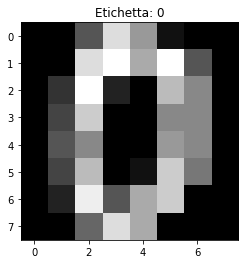

In [35]:
plt.imshow(digits.data[0].reshape((8,8)),cmap='gray')
plt.title("Etichetta: %d" % digits.target[0])
plt.show()

Supponiamo per un attimo che il dataset non sia etichettato, ma supponiamo comunque di sapere che contiene immagini delle 10 cifre scritte a mano. Proviamo a utilizzare l'algoritmo K-Means per cercare di suddividere i dati in $10$ gruppi:

In [36]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(digits.data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

L'algoritmo KMeans ha trovato $10$ centroidi e ha assegnato ogni campione di training a uno dei centroidi. I centroidi hanno la stessa dimensionalità dei dati in input ($64$ elementi) e pertanto anche essi possono essere visti come delle immagini $8 \times 8$. In particolare, ogni centroide è l'immagine media di tutte le immagini che sono state associate a quel cluster. Visualizziamo i 10 centroidi sotto forma di immagini:

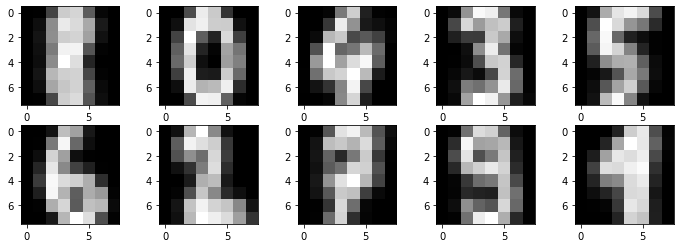

In [37]:
plt.figure(figsize=(12,4))

centroidi = kmeans.cluster_centers_

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(centroidi[i].reshape((8,8)),cmap='gray')
    
plt.show()

Ci aspetteremmo che il K-Means abbia messo in un dato cluster tutti e soli gli elementi appartenenti ad una data classe (ad esempio, un cluster dovrebbe contenere tutti e soli i campioni con etichetta "0"). In tal caso, si dice che il cluster "è puro". Diversi cluster possono avere diversi gradi di purezza.

Possiamo misurare la purezza di un cluster nel seguente modo:
 * Determiniamo l'etichetta più frequente tra quelle dei campioni di training assegnati al cluster;
 * Contiamo la frazione di elementi assegnati al cluster che abbiano etichetta corrispondente a quella più frequente.
Vediamo come fare:

In [38]:
from scipy.stats import mode
cluster_assignments = kmeans.labels_

purity = np.zeros(10)
most_frequent_label = np.zeros(10)

for c in range(10):
    training_labels = digits.target[cluster_assignments==c]
    #print(training_labels)
    most_frequent_label[c] = mode(training_labels).mode
    purity[c] = (training_labels==most_frequent_label[c]).mean()
    
    print("Cluster %d. Most frequent label: %d. Purity: %0.2f" % (c,most_frequent_label[c],purity[c]))

Cluster 0. Most frequent label: 8. Purity: 0.45
Cluster 1. Most frequent label: 0. Purity: 0.99
Cluster 2. Most frequent label: 4. Purity: 0.98
Cluster 3. Most frequent label: 3. Purity: 0.88
Cluster 4. Most frequent label: 5. Purity: 0.93
Cluster 5. Most frequent label: 6. Purity: 0.97
Cluster 6. Most frequent label: 2. Purity: 0.84
Cluster 7. Most frequent label: 7. Purity: 0.83
Cluster 8. Most frequent label: 9. Purity: 0.56
Cluster 9. Most frequent label: 1. Purity: 0.59


Visualizziamo adesso queste informazioni insieme alle immagini relative ai centroidi:

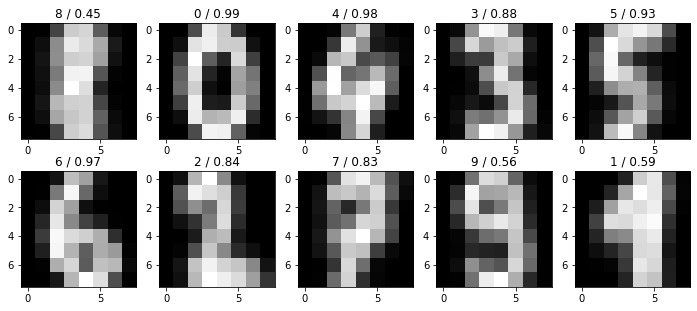

In [39]:
plt.figure(figsize=(12,5))

centroidi = kmeans.cluster_centers_

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(centroidi[i].reshape((8,8)),cmap='gray')
    plt.title("%d / %0.2f" % (most_frequent_label[i],purity[i]))
    
plt.show()

## 16.3 Gaussian Mixture Models (GMM)

L'algoritmo K-Means suddivide il training set in gruppi assegnando ognuno di essi ad un determinato centroide. Un'altra strategia consiste nel cercare di modellare la distribuzione multimodale dei dati e assegnare ogni dato alla moda più probabile. Volendo trovare $K$ clusters, supponiamo di modellare la distribuzione di dati come una mistura di $K$ Gaussiane (Mixture of Gaussians). In questo caso, la probabilità di un dato campione $\mathbf{x}$ sarà data da:

\begin{equation}
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}\ |\ \mathbf{\mu}_k, \sigma_k)
\end{equation}

dove:
 * $\pi_i$ sono i coefficienti della mistura di Gaussiane (i pesi delle singole Gaussiane);
 * $\mathbf{\mu}_k$ e $\mathbf{\sigma}_k$ sono le medie e covarianze delle singole Gaussiane.
 
Ogni Gaussiana del modello rappresenta uno dei cluster, mentre i coefficienti $\pi_i$ rappresentano "l'importanza" di ogni cluster. 

Il modello GMM è molto simile a quello offerto da K-Means ma con alcune importanti differenze:
 * Il modello GMM modella esplicitamente la distribuzione dei campioni in ingresso, permettendoci di calcolare per ogni campione il termine $p(x)$;
 * Il modello GMM effettua un "soft assignment" dei campioni ai cluster. A differenza di quanto avviene per K-Means, un campione non appartiene a un solo cluster (benché sia possibile determinare il cluster più probabile), ma ha una determinata probabilità di appartenere a ciascuno dei cluster considerati. Questo tipo di "soft assignment" permette di individuare i casi di incertezza (ad esempio nelle regioni di confine tra due cluster);
 * Il modello GMM modella ogni cluster con una distribuzione Gaussiana, mentre K-Means non determina esplicitamente le matrici di covarianza dei cluster, ma solo le medie. In un certo senso, è come se K-Means considerasse matrici di covarianza diagonali.

Torniamo al dataset Old Faithful e alleniamo un modello di tipo GMM su questi dati:

In [4]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4)
gmm.fit(faithful.data)

GaussianMixture(n_components=4)

Il modello ha trovato i valori più opportuni per i parametri $\mathbf{\mu}_k$, $\sigma_k$ e $\pi_k$. Vediamo come accedere a questi parametri:

In [5]:
print("Medie:\n",gmm.means_)
print()
print("Covarianze:\n",gmm.covariances_)
print()
print("Coefficienti:\n",gmm.weights_)

Medie:
 [[ 1.96368429 53.03819788]
 [ 4.26527199 83.64912798]
 [ 4.37318528 77.03925995]
 [ 2.55795639 61.71306761]]

Covarianze:
 [[[ 0.03335274  0.03704334]
  [ 0.03704334 25.02645751]]

 [[ 0.1653814   0.82024957]
  [ 0.82024957 23.35586099]]

 [[ 0.12085008  0.69727378]
  [ 0.69727378 17.32193777]]

 [[ 0.28224435  1.08049151]
  [ 1.08049151 29.78114965]]]

Coefficienti:
 [0.28515179 0.31594993 0.30842292 0.09047535]


Possiamo assegnare ogni punto al cluster più probabile come segue:

In [6]:
clusters = gmm.predict(faithful.data)
print(clusters)

[1 0 1 3 1 3 1 1 0 1 0 1 2 0 2 0 0 1 0 2 0 0 1 3 2 1 0 2 1 2 2 2 3 1 2 0 0
 2 0 1 2 0 1 0 2 1 2 0 2 0 2 1 0 2 0 2 2 0 2 1 0 1 0 2 0 1 2 2 0 2 1 0 2 2
 0 2 0 2 2 1 2 1 2 3 2 1 2 2 0 1 0 1 0 2 0 2 1 2 0 2 3 1 0 1 1 0 1 0 1 1 2
 0 1 2 0 2 0 1 0 1 3 2 2 0 1 1 0 1 0 1 0 1 3 1 0 1 0 1 0 1 1 0 2 2 2 0 2 0
 1 0 2 2 3 2 2 2 2 1 0 1 0 1 0 1 3 2 3 1 0 1 0 0 2 3 1 1 2 0 1 2 0 2 1 1 0
 2 1 0 1 0 2 0 2 1 2 1 1 2 0 2 0 1 1 0 2 0 2 1 0 1 3 2 0 2 3 2 0 1 0 2 0 1
 0 2 2 2 2 2 2 2 2 0 1 0 1 0 0 2 1 3 2 0 1 3 1 1 0 1 3 2 0 1 2 2 1 1 2 1 0
 2 2 1 0 1 0 0 2 1 0 1 0 2]


Costruiamo un DataFrame e visualizziamo gli asssegnamenti:

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
faithful_gmm = pd.DataFrame()
faithful_gmm['X'] = faithful.data['eruptions']
faithful_gmm['Y'] = faithful.data['waiting']
faithful_gmm['C'] = clusters

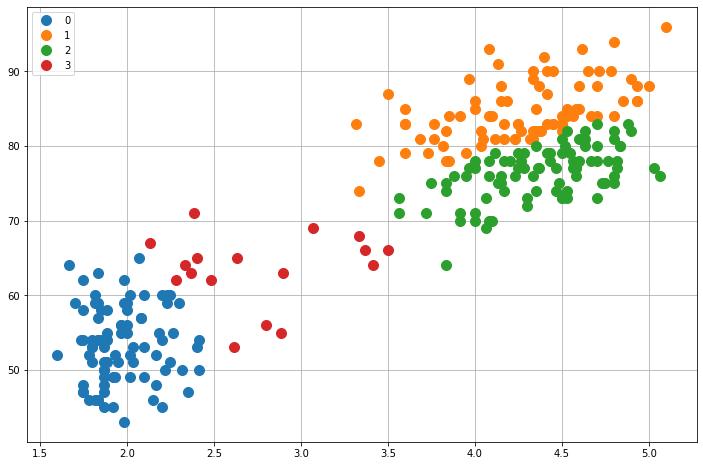

In [13]:
plt.figure(figsize=(12,8))
plot2d(faithful_gmm)
plt.grid()
plt.legend()
plt.show()

Visualizziamo le regioni di decisione trovate dal modello:

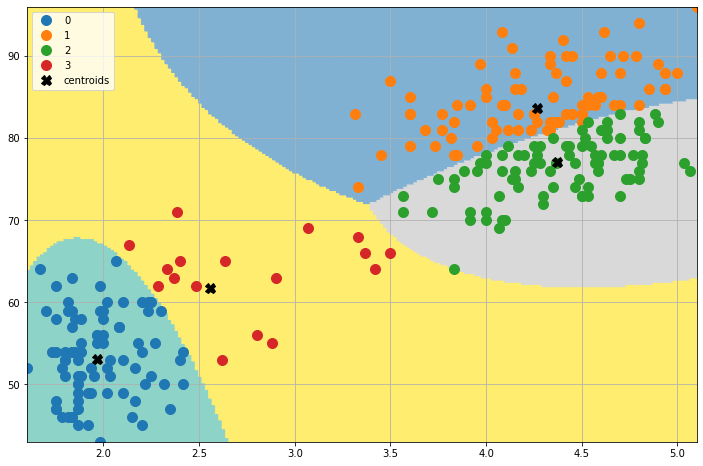

In [15]:
import numpy as np
def plot_gmm_decision_boundary(data, gmm):
    plot2d(data)
    X = np.linspace(data.X.min(), data.X.max(),200)
    Y = np.linspace(data.Y.min(), data.Y.max(),200)
    X,Y = np.meshgrid(X,Y)
    
    Z = gmm.predict(np.c_[X.ravel(), Y.ravel()])
    
    Z = np.array(Z).reshape(X.shape)
    
    plt.pcolormesh(X, Y, Z, antialiased=True, cmap='Set3')
    
    centers = gmm.means_
    
    plt.plot(centers[:,0],centers[:,1],'kX',markersize=10,label='centroids')

plt.figure(figsize=(12,8))
plot_gmm_decision_boundary(faithful_gmm,gmm)
plt.grid()
plt.legend()
plt.show()

Abbiamo detto che il modello GMM permette di effettuare un "soft assignment" calcolando le probabilità $p(\mathbf{x}\ |\ z_k)$. Per accedere alle distribuzioni di probabilità, possiamo utilizzare il metodo `predict_proba`:

In [18]:
cluster_probabilities = gmm.predict_proba(faithful.data)
print(cluster_probabilities.shape)
print(cluster_probabilities[0]*100)

(272, 4)
[2.03055818e-20 9.07598154e+01 8.91972276e+00 3.20461798e-01]


Per ogni elemento del dataset è stato calcolato un vettore bidimensionale che rappresenta la distribuzione di probabilità a posteriori $p(\mathbf{x}\ |\ z_k)$ per i due valori possibili di $k$. In pratica, il vettore ha componenti $[p(\mathbf{x}\ |\ z_0=1),\ p(\mathbf{x}\ |\ z_1=1)]$. Evidenziamo nel plot visto sopra i punti che presentano incertezza:

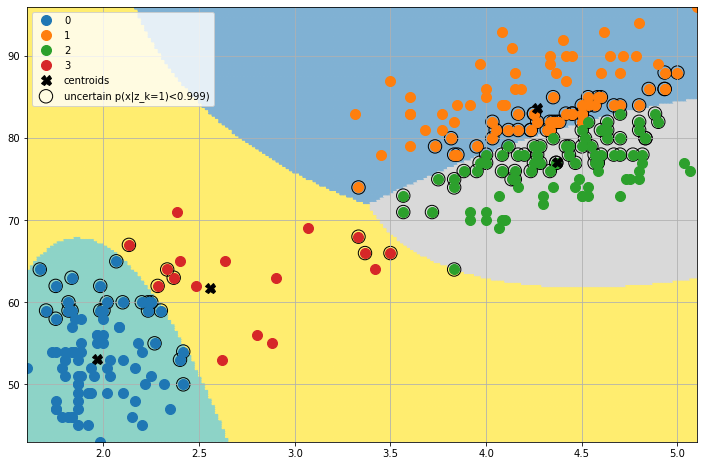

In [20]:
uncertain = cluster_probabilities.max(1)<0.90 #selezioniamo i punti a probabilità minore di 0.999

plt.figure(figsize=(12,8))
plot_gmm_decision_boundary(faithful_gmm,gmm)
plt.scatter(faithful_gmm['X'].values[uncertain],faithful_gmm['Y'].values[uncertain],180,
                facecolors='none',edgecolors='k', label='uncertain p(x|z_k=1)<0.999)')
plt.grid()
plt.legend()
plt.show()

## - KNN, Clustering - Fine